In [1]:
import kepler_utils.yields.janka as janka
import scipy.interpolate
import kepler_utils.yields.yields as yld
import kepler_utils.yields.integrator as integrator
import astropy.units as u
import numpy as np
import astropy.constants as consts

import matplotlib.pyplot as plt

janka_dir = "/Users/justinbrown/Dropbox/Research/Stan/Nucleosynthesis/links14/"
janka_calibrations = ["w15.0", "w18.0", "w20.0", "n20.0"]

lower_sn_limit = 8
remnant_approximation = "si"

for calibration in janka_calibrations:
    jp = None
    jps = []
    janka_files = ["results_%s_revised.txt" % calibration]
    for f in janka_files:
        jps.append (janka.JankaParser.readFrom (janka_dir + f))
        if jp is None:
            jp = jps [-1]
        else:
            jp += jps [-1]

    janka_imf = integrator.IMFIntegrator (jp [":M"])
    
    print ("Calibration: ", calibration)
    
    plt.figure ()
    plt.plot (jp [":M"], jp [":E_exp"])
    
    print ("E", janka_imf (jp [":E_exp"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True))
    
    print ("Ni Mass", janka_imf (jp [":with_fallback:M_outside(Ni)"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True), janka_imf (jp [":with_fallback:M_outside(Ni)"] + jp [":with_fallback:M_outside(Tr)"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True))
    
    newmasses = jp [":M"]
    new_imf = janka_imf
    mask = jp [":E_exp"].value > 0
    print ("Average Star Mass", new_imf (newmasses))
    print ("Average SN Mass", new_imf (newmasses, mask = mask, mask_frequency = True))

    print ("%", new_imf (newmasses / newmasses, mask = mask), new_imf (newmasses / newmasses, mask = np.logical_and (newmasses > 20.0 * u.solMass, mask)) / new_imf (newmasses / newmasses, mask = mask))
    print (new_imf (newmasses / newmasses, mask = np.logical_and (newmasses > 20.0 * u.solMass, mask)) / new_imf (newmasses / newmasses, mask = mask))
    
    wdata = np.genfromtxt ("../wcores.dat", names = True)
    w_imf = integrator.IMFIntegrator (wdata ["Minit"] * u.solMass)
    w_remnants = wdata [remnant_approximation] * u.solMass
        
    baryonic_masses = u.Quantity (list (w_remnants) + list (jp [":with_fallback:M_mass_cut_after_fb"]))
    
    baryonic_masses [baryonic_masses > 2.5 * u.solMass] = 0. * u.solMass
    integrated_baryonic_mass = (w_imf + janka_imf) (baryonic_masses, mask = baryonic_masses > 0.0 * u.solMass, mask_frequency = True)
    print ("M_remnant", integrated_baryonic_mass, integrated_baryonic_mass * (1 - 3.0 / 5.0 * consts.G * integrated_baryonic_mass / (12 * u.km * consts.c ** 2)))
    
#     full_imf = integrator.IMFIntegrator (np.arange (9,15,0.1) * u.solMass)) + 
    
#     mask = np.array (list (np.arange (9,15,0.1)>0) + list (jp [":E_exp"].value > 0)), dtype = bool)
#     print (new_imf (newmasses, mask = mask, mask_frequency = True))
#     print (new_imf (newmasses / newmasses, mask = mask))

Calibration:  w15.0
E 7.020825074388177e+50 erg
Ni Mass 0.04340067494865211 solMass 0.054144920212918606 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 14.40349659270851 solMass
% 0.6321283734419516 0.08695786396950189
0.08695786396950189
M_remnant 1.5385486901607475 solMass 1.3637317573827592 solMass
Calibration:  w18.0
E 7.393352094162265e+50 erg
Ni Mass 0.045985653779243414 solMass 0.057612915654103855 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 14.59030823254528 solMass
% 0.6454122115866211 0.1002233947383398
0.1002233947383398
M_remnant 1.5441815777822332 solMass 1.368082232866112 solMass
Calibration:  w20.0
E 5.998032785730114e+50 erg
Ni Mass 0.0357769104951432 solMass 0.043524129422073156 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 12.364339343151762 solMass
% 0.49485399894005083 0.03971822283803301
0.03971822283803301
M_remnant 1.5387882592043287 solMass 1.3639168803287922 solMass
Calibration:  n20.0
E 8.93

In [3]:
janka.JankaParser.readFrom (janka_dir + "results_w18.0_revised.txt")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/justinbrown/Dropbox/Research/Stan/Nucleosynthesis/links14/results_w18_revised.txt'

In [1]:
import numpy as np
from pandas import read_csv

data = read_csv ("../nucleo.dat", header = 1, index_col = "grid", sep = r"\s{2,}", engine = "python")
data = data.replace ("---", 0.0).fillna (0.0)
data.columns = map (str.lower, data.columns)
data.pop ("network")
v = data.pop ("stability")

data ["ca44"] = data.pop ("ti44")
data ["ti48"] = data.pop ("cr48")
data ["cr52"] = data.pop ("fe52")
data ["fe56"] += data.pop ("ni56")

dmass = np.concatenate ([np.diff (data ["cell outer total mass"]), [0.]])

for key in data.keys ():
    if key [:4] == "cell":
        data.pop (key)
v = data.pop ("'fe'")

prod = data.mul (dmass, axis = 0).sum ()

In [2]:
from kepler_utils.yields.yields import CompositeYieldReader, Isotope
import astropy.units as u

total = CompositeYieldReader ([u.Quantity ([15.2], u.solMass)], [Isotope.fromList (prod.keys ())], [[prod]], scale = u.g.to (u.solMass))

In [6]:
a = data [:np.argmax (data ["s32"] + data ["si28"] > 0.01)].mean ()
a = a * (0.078684 * u.solMass - total.get_yield ("fe56")).to (u.g).value / a ["fe56"] + prod

combined = CompositeYieldReader ([u.Quantity ([15.2], u.solMass)], [Isotope.fromList (a.keys ())], [[a]], scale = u.g.to (u.solMass))

1.0
1.0


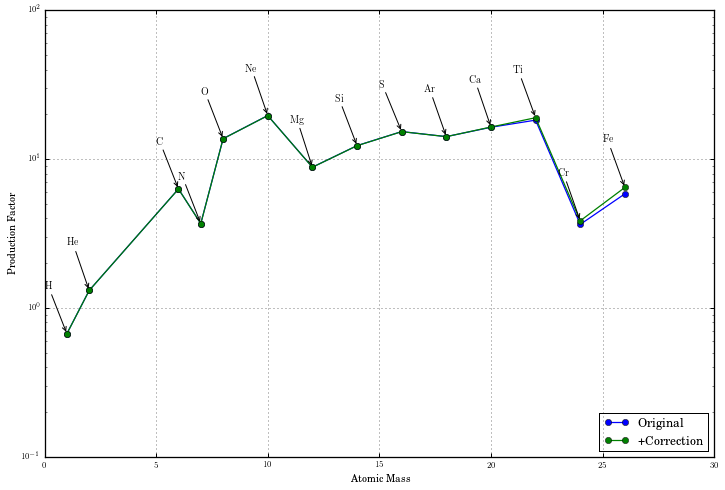

In [13]:
from kepler_utils.plots.yields import YieldPlot
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots (1, 1, sharex = True, figsize = (12, 8))

colors = iter (["blue", "green"])

for yr in [total, combined]:
    p = YieldPlot (yr)
    p.plot (axis, c = next (colors), names = yr == combined, label = "+Correction" if yr == combined else "Original")
    
axis.legend (loc = "lower right")

In [19]:
(0.078684 * u.solMass - total.get_yield ("fe56")).to (u.g).value / a ["fe56"]

array([  2.50341362e+31])

In [18]:
a = data [:np.argmax (data ["s32"] + data ["si28"] > 0.01)].mean ()

In [42]:
syr.yields

,al27,ar36,ar38,ar40,as75,b10,b11,be9,br79,br81,...,w183,w184,w186,yb168,yb170,yb171,yb172,yb173,yb174,yb176
36,0.004554,0.013115,0.004605,0.000003,0.000001,3.142000e-09,0.000002,2.489000e-10,0.000001,0,...,1.390000e-09,2.921000e-09,2.996000e-09,1.789000e-11,6.221000e-10,2.249000e-09,3.542000e-09,2.526000e-09,5.549000e-09,2.302000e-09


In [45]:
syr.yields

,al27,ar36,ar38,ar40,as75,b10,b11,be9,br79,br81,...,w183,w184,w186,yb168,yb170,yb171,yb172,yb173,yb174,yb176
36,0.004554,0.0131,0.004605,0.000003,0.000001,3.142000e-09,0.000002,2.489000e-10,0.000001,0,...,1.390000e-09,2.921000e-09,2.996000e-09,1.789000e-11,6.221000e-10,2.249000e-09,3.542000e-09,2.526000e-09,5.549000e-09,2.302000e-09


In [35]:
syr.yields.iloc [0].add (final, fill_value = 0) ["h1"]

14.166000000000711

In [3]:
from kepler_utils.yields.yields import YieldReader

In [4]:
yr = YieldReader.from_directory ("../yields/wh07/", explosions = False, table = 2, totalYieldName = "yield0all", windYieldName = "yield0wnd")

In [5]:
xyr = YieldReader.from_directory ("../yields/yields_incomplete_W18/", winds = False, table = 2, totalYieldName = "yield0all", windYieldName = "yield0wnd")

In [6]:
yr.get_yield ("fe60") / yr.get_yield ("al26")

<Quantity [  1.18408282e-35,  1.87335341e-35,  5.89970282e-35,
             1.83298008e-34,  3.00226244e-34,  3.69502949e-34,
             3.73690878e-34,  3.89646357e-34,  1.10601683e-17,
             1.37380801e-15,  1.03824921e-14,  2.12384806e-13,
             6.42212190e-13,  2.55585586e-12,  1.05639615e-11,
             7.01901813e-11,  1.46295745e-10,  2.15384615e-10,
             2.55497210e-10,  2.77264562e-10,  2.80765456e-10,
             3.08099688e-10,  3.66071429e-10,  4.89866821e-10,
             7.39699929e-10,  7.96207936e-04,  1.05001038e-04,
             3.61777778e-06,  5.85822306e-08,  1.40747843e-08,
             1.90413119e-07,  8.75307125e-08]>

In [8]:
for mass, ratio in zip (xyr.masses, xyr.get_yield ("al26") / xyr.get_yield ("fe60")):
    print (mass, ratio)

12.0 solMass 0.9400753060728745
12.1 solMass 1.7036945592592592
12.2 solMass 1.1904215368421054
12.3 solMass 0.7972689248704663
12.4 solMass 0.5111031869918699
12.5 solMass 0.43766866552242006
12.6 solMass 0.4690818501493909
12.7 solMass 0.5608373716295428
12.8 solMass 0.5098768552797643
12.9 solMass 0.44448333056133055
13.0 solMass 0.4635855824478552
13.1 solMass 0.4798087247780468
13.2 solMass 0.5070067644628099
13.3 solMass 0.47009045317788645
13.4 solMass 0.44053620534943916
13.5 solMass 0.4289331107029554
13.6 solMass 0.30322756944444446
13.7 solMass 0.3114390426612494
13.8 solMass 0.41696083425110136
13.9 solMass 0.3054236954141831
14.0 solMass 0.4655151030087446
14.1 solMass 0.4949442108517545
14.2 solMass 0.6346706276445698
14.3 solMass 0.533712395337383
14.4 solMass 0.5088454007358824
14.5 solMass 0.5559221785636324
14.6 solMass 0.5506548564338887
14.7 solMass 0.5464468148487626
14.8 solMass 0.72916397195298
14.9 solMass 0.6727131573344689
15.0 solMass nan
15.1 solMass nan
15.

In [9]:
from kepler_utils.yields.integrator import IMFIntegrator

In [10]:
imf = IMFIntegrator.from_yieldreader (xyr)

In [11]:
imf (xyr.get_yield ("al26")) / imf (xyr.get_yield ("fe60"))

<Quantity 0.5631427645776605>